In [7]:
# Import
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/user/workdir/main/src/'))))

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# Training (Nitrate)

In [9]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [10]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 32  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )

# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 5e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-02-06 21:44:22.861892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22337 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-02-06 21:44:22.863472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22337 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-02-06 21:44:22.865003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22337 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-02-06 21:44:22.866525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21929 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-02-06 21:44:49.037274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-06 21:44:49.062915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-06 21:44:49.092491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-06 21:44:49.199036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-06 21:44:51.822095: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f693b619b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-06 21:44:51.822152: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-06 21:44:51.822165: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-06 21:44:51.82217

3/3 [==============================] - ETA: 0s - loss: 25.7941INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-01-29.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-01-29.83/assets


3/3 [==============================] - 45s 7s/step - loss: 25.7941 - val_loss: 29.8338 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 22.8370INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-02-29.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-02-29.63/assets


3/3 [==============================] - 9s 5s/step - loss: 22.8370 - val_loss: 29.6321 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 19.6484INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-03-29.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-03-29.27/assets


3/3 [==============================] - 10s 5s/step - loss: 19.6484 - val_loss: 29.2748 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 17.9391INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-04-28.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-04-28.76/assets


3/3 [==============================] - 9s 5s/step - loss: 17.9391 - val_loss: 28.7551 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - ETA: 0s - loss: 17.0612INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-05-28.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-05-28.13/assets


3/3 [==============================] - 9s 5s/step - loss: 17.0612 - val_loss: 28.1254 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - ETA: 0s - loss: 16.4918INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-06-27.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-06-27.46/assets


3/3 [==============================] - 9s 5s/step - loss: 16.4918 - val_loss: 27.4577 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - ETA: 0s - loss: 16.0686INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-07-26.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-07-26.79/assets


3/3 [==============================] - 9s 5s/step - loss: 16.0686 - val_loss: 26.7876 - lr: 0.0010
Epoch 8/1000
2/3 [===================>..........] - ETA: 0s - loss: 15.7706INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-08-26.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-08-26.18/assets


3/3 [==============================] - 9s 5s/step - loss: 15.7067 - val_loss: 26.1821 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - ETA: 0s - loss: 15.3631INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-09-25.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-09-25.64/assets


3/3 [==============================] - 10s 5s/step - loss: 15.3631 - val_loss: 25.6375 - lr: 0.0010
Epoch 10/1000
3/3 [==============================] - ETA: 0s - loss: 14.9824INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-10-25.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-10-25.22/assets


3/3 [==============================] - 10s 5s/step - loss: 14.9824 - val_loss: 25.2210 - lr: 0.0010
Epoch 11/1000
3/3 [==============================] - ETA: 0s - loss: 14.5872INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-11-24.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-11-24.93/assets


3/3 [==============================] - 10s 5s/step - loss: 14.5872 - val_loss: 24.9329 - lr: 0.0010
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 14.2725INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-12-24.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-12-24.72/assets


3/3 [==============================] - 10s 5s/step - loss: 14.2725 - val_loss: 24.7219 - lr: 0.0010
Epoch 13/1000
3/3 [==============================] - ETA: 0s - loss: 13.9814INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-13-24.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-13-24.43/assets


3/3 [==============================] - 10s 5s/step - loss: 13.9814 - val_loss: 24.4304 - lr: 0.0010
Epoch 14/1000
2/3 [===================>..........] - ETA: 0s - loss: 13.7119INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-14-24.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-14-24.19/assets


3/3 [==============================] - 10s 5s/step - loss: 13.6998 - val_loss: 24.1898 - lr: 0.0010
Epoch 15/1000
2/3 [===================>..........] - ETA: 0s - loss: 13.4680INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-15-24.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-15-24.13/assets


3/3 [==============================] - 10s 5s/step - loss: 13.4316 - val_loss: 24.1274 - lr: 0.0010
Epoch 16/1000
3/3 [==============================] - ETA: 0s - loss: 13.1668INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-16-24.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-16-24.10/assets


3/3 [==============================] - 10s 5s/step - loss: 13.1668 - val_loss: 24.0982 - lr: 0.0010
Epoch 17/1000
3/3 [==============================] - ETA: 0s - loss: 12.9201INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-17-24.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-17-24.04/assets


3/3 [==============================] - 8s 4s/step - loss: 12.9201 - val_loss: 24.0363 - lr: 0.0010
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 12.6730INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-18-23.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-18-23.93/assets


3/3 [==============================] - 11s 5s/step - loss: 12.6730 - val_loss: 23.9279 - lr: 0.0010
Epoch 19/1000
2/3 [===================>..........] - ETA: 0s - loss: 12.4436INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-19-23.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-19-23.74/assets


3/3 [==============================] - 8s 4s/step - loss: 12.4311 - val_loss: 23.7360 - lr: 0.0010
Epoch 20/1000
3/3 [==============================] - ETA: 0s - loss: 12.1932INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-20-23.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-20-23.50/assets


3/3 [==============================] - 11s 5s/step - loss: 12.1932 - val_loss: 23.5011 - lr: 0.0010
Epoch 21/1000
3/3 [==============================] - ETA: 0s - loss: 11.9539INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-21-23.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-21-23.36/assets


3/3 [==============================] - 8s 4s/step - loss: 11.9539 - val_loss: 23.3594 - lr: 0.0010
Epoch 22/1000
3/3 [==============================] - ETA: 0s - loss: 11.7178INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-22-23.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-22-23.16/assets


3/3 [==============================] - 10s 5s/step - loss: 11.7178 - val_loss: 23.1599 - lr: 0.0010
Epoch 23/1000
3/3 [==============================] - ETA: 0s - loss: 11.4876INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-23-23.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-23-23.01/assets


3/3 [==============================] - 10s 5s/step - loss: 11.4876 - val_loss: 23.0065 - lr: 0.0010
Epoch 24/1000
3/3 [==============================] - ETA: 0s - loss: 11.2622INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-24-22.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-24-22.70/assets


3/3 [==============================] - 10s 5s/step - loss: 11.2622 - val_loss: 22.6988 - lr: 0.0010
Epoch 25/1000
3/3 [==============================] - ETA: 0s - loss: 11.0365INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-25-22.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-25-22.47/assets


3/3 [==============================] - 10s 5s/step - loss: 11.0365 - val_loss: 22.4706 - lr: 0.0010
Epoch 26/1000
3/3 [==============================] - ETA: 0s - loss: 10.8093INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-26-22.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-26-22.18/assets


3/3 [==============================] - 10s 5s/step - loss: 10.8093 - val_loss: 22.1767 - lr: 0.0010
Epoch 27/1000
3/3 [==============================] - ETA: 0s - loss: 10.5928INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-27-21.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-27-21.96/assets


3/3 [==============================] - 10s 5s/step - loss: 10.5928 - val_loss: 21.9621 - lr: 0.0010
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 10.3793INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-28-21.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-28-21.76/assets


3/3 [==============================] - 10s 5s/step - loss: 10.3793 - val_loss: 21.7566 - lr: 0.0010
Epoch 29/1000
3/3 [==============================] - ETA: 0s - loss: 10.1703INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-29-21.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-29-21.59/assets


3/3 [==============================] - 10s 5s/step - loss: 10.1703 - val_loss: 21.5915 - lr: 0.0010
Epoch 30/1000
3/3 [==============================] - ETA: 0s - loss: 9.9670INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-30-21.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-30-21.42/assets


3/3 [==============================] - 10s 5s/step - loss: 9.9670 - val_loss: 21.4224 - lr: 0.0010
Epoch 31/1000
3/3 [==============================] - ETA: 0s - loss: 9.7676INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-31-21.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-31-21.16/assets


3/3 [==============================] - 10s 5s/step - loss: 9.7676 - val_loss: 21.1573 - lr: 0.0010
Epoch 32/1000
3/3 [==============================] - ETA: 0s - loss: 9.5749INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-32-21.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-32-21.01/assets


3/3 [==============================] - 9s 4s/step - loss: 9.5749 - val_loss: 21.0053 - lr: 0.0010
Epoch 33/1000
2/3 [===================>..........] - ETA: 0s - loss: 9.3712INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-33-20.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-33-20.75/assets


3/3 [==============================] - 10s 5s/step - loss: 9.3859 - val_loss: 20.7541 - lr: 0.0010
Epoch 34/1000
3/3 [==============================] - ETA: 0s - loss: 9.2056INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-34-20.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-34-20.38/assets


3/3 [==============================] - 10s 5s/step - loss: 9.2056 - val_loss: 20.3842 - lr: 0.0010
Epoch 35/1000
3/3 [==============================] - ETA: 0s - loss: 9.0170INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-35-20.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-35-20.11/assets


3/3 [==============================] - 10s 5s/step - loss: 9.0170 - val_loss: 20.1113 - lr: 0.0010
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 8.8350INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-36-19.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-36-19.91/assets


3/3 [==============================] - 10s 5s/step - loss: 8.8350 - val_loss: 19.9122 - lr: 0.0010
Epoch 37/1000
3/3 [==============================] - ETA: 0s - loss: 8.6582INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-37-19.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-37-19.62/assets


3/3 [==============================] - 10s 5s/step - loss: 8.6582 - val_loss: 19.6182 - lr: 0.0010
Epoch 38/1000
3/3 [==============================] - ETA: 0s - loss: 8.4840INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-38-19.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-38-19.28/assets


3/3 [==============================] - 8s 4s/step - loss: 8.4840 - val_loss: 19.2806 - lr: 0.0010
Epoch 39/1000
2/3 [===================>..........] - ETA: 0s - loss: 8.3381INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-39-19.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-39-19.09/assets


3/3 [==============================] - 10s 5s/step - loss: 8.3136 - val_loss: 19.0905 - lr: 0.0010
Epoch 40/1000
3/3 [==============================] - ETA: 0s - loss: 8.1458INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-40-18.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-40-18.78/assets


3/3 [==============================] - 10s 5s/step - loss: 8.1458 - val_loss: 18.7769 - lr: 0.0010
Epoch 41/1000
3/3 [==============================] - ETA: 0s - loss: 7.9775INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-41-18.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-41-18.40/assets


3/3 [==============================] - 10s 5s/step - loss: 7.9775 - val_loss: 18.4006 - lr: 0.0010
Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 7.8137INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-42-18.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-42-18.14/assets


3/3 [==============================] - 8s 4s/step - loss: 7.8137 - val_loss: 18.1435 - lr: 0.0010
Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 7.6506INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-43-18.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-43-18.01/assets


3/3 [==============================] - 10s 5s/step - loss: 7.6506 - val_loss: 18.0082 - lr: 0.0010
Epoch 44/1000
2/3 [===================>..........] - ETA: 0s - loss: 7.4702INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-44-17.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-44-17.69/assets


3/3 [==============================] - 10s 5s/step - loss: 7.4909 - val_loss: 17.6909 - lr: 0.0010
Epoch 45/1000
2/3 [===================>..........] - ETA: 0s - loss: 7.3437INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-45-17.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-45-17.34/assets


3/3 [==============================] - 10s 5s/step - loss: 7.3330 - val_loss: 17.3386 - lr: 0.0010
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 7.1748INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-46-17.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-46-17.04/assets


3/3 [==============================] - 8s 4s/step - loss: 7.1748 - val_loss: 17.0373 - lr: 0.0010
Epoch 47/1000
3/3 [==============================] - ETA: 0s - loss: 7.0229INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-47-16.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-47-16.85/assets


3/3 [==============================] - 10s 5s/step - loss: 7.0229 - val_loss: 16.8513 - lr: 0.0010
Epoch 48/1000
3/3 [==============================] - ETA: 0s - loss: 6.8699INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-48-16.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-48-16.66/assets


3/3 [==============================] - 10s 5s/step - loss: 6.8699 - val_loss: 16.6634 - lr: 0.0010
Epoch 49/1000
3/3 [==============================] - ETA: 0s - loss: 6.7181INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-49-16.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-49-16.50/assets


3/3 [==============================] - 10s 5s/step - loss: 6.7181 - val_loss: 16.4990 - lr: 0.0010
Epoch 50/1000
3/3 [==============================] - ETA: 0s - loss: 6.5739INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-50-16.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-50-16.12/assets


3/3 [==============================] - 8s 4s/step - loss: 6.5739 - val_loss: 16.1203 - lr: 0.0010
Epoch 51/1000
2/3 [===================>..........] - ETA: 0s - loss: 6.4210INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-51-15.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-51-15.78/assets


3/3 [==============================] - 10s 5s/step - loss: 6.4265 - val_loss: 15.7840 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 6.2813INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-52-15.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-52-15.58/assets


3/3 [==============================] - 10s 5s/step - loss: 6.2813 - val_loss: 15.5849 - lr: 0.0010
Epoch 53/1000
2/3 [===================>..........] - ETA: 0s - loss: 6.1510INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-53-15.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-53-15.32/assets


3/3 [==============================] - 8s 4s/step - loss: 6.1369 - val_loss: 15.3171 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 5.9989INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-54-15.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-54-15.17/assets


3/3 [==============================] - 11s 5s/step - loss: 5.9989 - val_loss: 15.1719 - lr: 0.0010
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 5.8630INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-55-15.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-55-15.13/assets


3/3 [==============================] - 10s 5s/step - loss: 5.8630 - val_loss: 15.1335 - lr: 0.0010
Epoch 56/1000
2/3 [===================>..........] - ETA: 0s - loss: 5.7382INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-56-14.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-56-14.84/assets


3/3 [==============================] - 8s 4s/step - loss: 5.7293 - val_loss: 14.8410 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 5.5984INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-57-14.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-57-14.65/assets


3/3 [==============================] - 10s 5s/step - loss: 5.5984 - val_loss: 14.6478 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 5.4691INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-58-14.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-58-14.28/assets


3/3 [==============================] - 8s 4s/step - loss: 5.4691 - val_loss: 14.2785 - lr: 0.0010
Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 5.3429INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-59-13.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-59-13.94/assets


3/3 [==============================] - 10s 5s/step - loss: 5.3429 - val_loss: 13.9428 - lr: 0.0010
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 5.2186INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-60-13.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-60-13.64/assets


3/3 [==============================] - 10s 5s/step - loss: 5.2186 - val_loss: 13.6379 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 5.0984INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-61-13.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-61-13.46/assets


3/3 [==============================] - 8s 4s/step - loss: 5.0984 - val_loss: 13.4633 - lr: 0.0010
Epoch 62/1000
3/3 [==============================] - ETA: 0s - loss: 4.9789INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-62-13.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-62-13.27/assets


3/3 [==============================] - 10s 5s/step - loss: 4.9789 - val_loss: 13.2713 - lr: 0.0010
Epoch 63/1000
3/3 [==============================] - ETA: 0s - loss: 4.8634INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-63-12.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-63-12.97/assets


3/3 [==============================] - 10s 5s/step - loss: 4.8634 - val_loss: 12.9693 - lr: 0.0010
Epoch 64/1000
3/3 [==============================] - ETA: 0s - loss: 4.7537INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-64-12.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-64-12.70/assets


3/3 [==============================] - 8s 4s/step - loss: 4.7537 - val_loss: 12.6987 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - ETA: 0s - loss: 4.6377INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-65-12.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-65-12.62/assets


3/3 [==============================] - 10s 5s/step - loss: 4.6377 - val_loss: 12.6188 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - ETA: 0s - loss: 4.5307INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-66-12.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-66-12.48/assets


3/3 [==============================] - 10s 5s/step - loss: 4.5307 - val_loss: 12.4765 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - ETA: 0s - loss: 4.4231INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-67-12.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-67-12.24/assets


3/3 [==============================] - 8s 4s/step - loss: 4.4231 - val_loss: 12.2408 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 4.3186INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-68-12.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-68-12.01/assets


3/3 [==============================] - 10s 5s/step - loss: 4.3186 - val_loss: 12.0130 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 4.2116INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-69-11.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-69-11.67/assets


3/3 [==============================] - 10s 5s/step - loss: 4.2116 - val_loss: 11.6748 - lr: 0.0010
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 4.1092INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-70-11.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-70-11.30/assets


3/3 [==============================] - 8s 4s/step - loss: 4.1092 - val_loss: 11.3000 - lr: 0.0010
Epoch 71/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.9960INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-71-11.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-71-11.13/assets


3/3 [==============================] - 10s 5s/step - loss: 4.0123 - val_loss: 11.1291 - lr: 0.0010
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 3.9126INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-72-11.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-72-11.10/assets


3/3 [==============================] - 9s 4s/step - loss: 3.9126 - val_loss: 11.1041 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 3.8199INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-73-10.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-73-10.69/assets


3/3 [==============================] - 11s 5s/step - loss: 3.8199 - val_loss: 10.6945 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - 0s 196ms/step - loss: 3.7216 - val_loss: 10.7271 - lr: 0.0010
Epoch 75/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.6139INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-75-10.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-75-10.57/assets


3/3 [==============================] - 8s 4s/step - loss: 3.6305 - val_loss: 10.5670 - lr: 0.0010
Epoch 76/1000
3/3 [==============================] - ETA: 0s - loss: 3.5377INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-76-10.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-76-10.11/assets


3/3 [==============================] - 11s 5s/step - loss: 3.5377 - val_loss: 10.1097 - lr: 0.0010
Epoch 77/1000
3/3 [==============================] - ETA: 0s - loss: 3.4489INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-77-9.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-77-9.89/assets


3/3 [==============================] - 10s 5s/step - loss: 3.4489 - val_loss: 9.8866 - lr: 0.0010
Epoch 78/1000
3/3 [==============================] - ETA: 0s - loss: 3.3614INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-78-9.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-78-9.77/assets


3/3 [==============================] - 8s 4s/step - loss: 3.3614 - val_loss: 9.7655 - lr: 0.0010
Epoch 79/1000
3/3 [==============================] - ETA: 0s - loss: 3.2761INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-79-9.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-79-9.50/assets


3/3 [==============================] - 11s 5s/step - loss: 3.2761 - val_loss: 9.4985 - lr: 0.0010
Epoch 80/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.1984INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-80-9.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-80-9.29/assets


3/3 [==============================] - 9s 4s/step - loss: 3.1945 - val_loss: 9.2859 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 3.1136INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-81-9.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-81-9.06/assets


3/3 [==============================] - 11s 5s/step - loss: 3.1136 - val_loss: 9.0562 - lr: 0.0010
Epoch 82/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.0464INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-82-9.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-82-9.02/assets


3/3 [==============================] - 8s 4s/step - loss: 3.0336 - val_loss: 9.0189 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 2.9533INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-83-8.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-83-8.74/assets


3/3 [==============================] - 11s 5s/step - loss: 2.9533 - val_loss: 8.7421 - lr: 0.0010
Epoch 84/1000
3/3 [==============================] - ETA: 0s - loss: 2.8755INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-84-8.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-84-8.31/assets


3/3 [==============================] - 8s 4s/step - loss: 2.8755 - val_loss: 8.3076 - lr: 0.0010
Epoch 85/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.7866INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-85-8.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-85-8.07/assets


3/3 [==============================] - 11s 5s/step - loss: 2.7991 - val_loss: 8.0665 - lr: 0.0010
Epoch 86/1000
3/3 [==============================] - ETA: 0s - loss: 2.7295INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-86-8.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-86-8.00/assets


3/3 [==============================] - 8s 4s/step - loss: 2.7295 - val_loss: 7.9972 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 2.6545INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-87-7.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-87-7.75/assets


3/3 [==============================] - 11s 6s/step - loss: 2.6545 - val_loss: 7.7465 - lr: 0.0010
Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 2.5862INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-88-7.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-88-7.52/assets


3/3 [==============================] - 11s 5s/step - loss: 2.5862 - val_loss: 7.5198 - lr: 0.0010
Epoch 89/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.5248INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-89-7.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-89-7.44/assets


3/3 [==============================] - 9s 4s/step - loss: 2.5174 - val_loss: 7.4386 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - ETA: 0s - loss: 2.4483INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-90-7.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-90-7.28/assets


3/3 [==============================] - 11s 5s/step - loss: 2.4483 - val_loss: 7.2827 - lr: 0.0010
Epoch 91/1000
3/3 [==============================] - ETA: 0s - loss: 2.3791INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-91-7.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-91-7.18/assets


3/3 [==============================] - 9s 4s/step - loss: 2.3791 - val_loss: 7.1834 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 2.3134INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-92-7.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-92-7.12/assets


3/3 [==============================] - 11s 5s/step - loss: 2.3134 - val_loss: 7.1194 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 2.2506INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-93-7.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-93-7.07/assets


3/3 [==============================] - 9s 4s/step - loss: 2.2506 - val_loss: 7.0716 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - ETA: 0s - loss: 2.1873INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-94-6.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-94-6.78/assets


3/3 [==============================] - 8s 4s/step - loss: 2.1873 - val_loss: 6.7824 - lr: 0.0010
Epoch 95/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.1414INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-95-6.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-95-6.58/assets


3/3 [==============================] - 11s 6s/step - loss: 2.1256 - val_loss: 6.5769 - lr: 0.0010
Epoch 96/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.0820INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-96-6.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-96-6.46/assets


3/3 [==============================] - 11s 5s/step - loss: 2.0659 - val_loss: 6.4598 - lr: 0.0010
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 2.0072INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-97-6.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-97-6.29/assets


3/3 [==============================] - 8s 4s/step - loss: 2.0072 - val_loss: 6.2946 - lr: 0.0010
Epoch 98/1000
3/3 [==============================] - ETA: 0s - loss: 1.9513INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-98-6.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-98-6.16/assets


3/3 [==============================] - 8s 4s/step - loss: 1.9513 - val_loss: 6.1558 - lr: 0.0010
Epoch 99/1000
3/3 [==============================] - ETA: 0s - loss: 1.8969INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-99-6.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-99-6.00/assets


3/3 [==============================] - 11s 6s/step - loss: 1.8969 - val_loss: 5.9989 - lr: 0.0010
Epoch 100/1000
3/3 [==============================] - ETA: 0s - loss: 1.8454INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-100-5.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-100-5.83/assets


3/3 [==============================] - 11s 5s/step - loss: 1.8454 - val_loss: 5.8304 - lr: 0.0010
Epoch 101/1000
3/3 [==============================] - 0s 211ms/step - loss: 1.7889 - val_loss: 5.8485 - lr: 0.0010
Epoch 102/1000
3/3 [==============================] - ETA: 0s - loss: 1.7392INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-102-5.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-102-5.71/assets


3/3 [==============================] - 8s 4s/step - loss: 1.7392 - val_loss: 5.7147 - lr: 0.0010
Epoch 103/1000
3/3 [==============================] - ETA: 0s - loss: 1.6885INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-103-5.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-103-5.53/assets


3/3 [==============================] - 8s 4s/step - loss: 1.6885 - val_loss: 5.5327 - lr: 0.0010
Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 1.6381INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-104-5.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-104-5.38/assets


3/3 [==============================] - 11s 6s/step - loss: 1.6381 - val_loss: 5.3783 - lr: 0.0010
Epoch 105/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5728INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-105-5.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-105-5.03/assets


3/3 [==============================] - 8s 4s/step - loss: 1.5895 - val_loss: 5.0335 - lr: 0.0010
Epoch 106/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5448INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-106-4.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-106-4.78/assets


3/3 [==============================] - 11s 6s/step - loss: 1.5445 - val_loss: 4.7771 - lr: 0.0010
Epoch 107/1000
3/3 [==============================] - 0s 209ms/step - loss: 1.4966 - val_loss: 4.7849 - lr: 0.0010
Epoch 108/1000
3/3 [==============================] - 0s 221ms/step - loss: 1.4498 - val_loss: 4.8853 - lr: 0.0010
Epoch 109/1000
3/3 [==============================] - ETA: 0s - loss: 1.4066INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-109-4.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-109-4.69/assets


3/3 [==============================] - 8s 4s/step - loss: 1.4066 - val_loss: 4.6909 - lr: 0.0010
Epoch 110/1000
3/3 [==============================] - ETA: 0s - loss: 1.3620INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-110-4.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-110-4.44/assets


3/3 [==============================] - 11s 6s/step - loss: 1.3620 - val_loss: 4.4403 - lr: 0.0010
Epoch 111/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3296INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-111-4.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-111-4.42/assets


3/3 [==============================] - 8s 4s/step - loss: 1.3202 - val_loss: 4.4162 - lr: 0.0010
Epoch 112/1000
3/3 [==============================] - ETA: 0s - loss: 1.2783INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-112-4.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-112-4.19/assets


3/3 [==============================] - 11s 6s/step - loss: 1.2783 - val_loss: 4.1923 - lr: 0.0010
Epoch 113/1000
3/3 [==============================] - ETA: 0s - loss: 1.2406INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-113-4.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-113-4.13/assets


3/3 [==============================] - 8s 4s/step - loss: 1.2406 - val_loss: 4.1348 - lr: 0.0010
Epoch 114/1000
3/3 [==============================] - ETA: 0s - loss: 1.2007INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-114-4.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-114-4.08/assets


3/3 [==============================] - 11s 6s/step - loss: 1.2007 - val_loss: 4.0846 - lr: 0.0010
Epoch 115/1000
3/3 [==============================] - ETA: 0s - loss: 1.1629INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-115-4.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-115-4.00/assets


3/3 [==============================] - 8s 4s/step - loss: 1.1629 - val_loss: 4.0001 - lr: 0.0010
Epoch 116/1000
3/3 [==============================] - ETA: 0s - loss: 1.1254INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-116-3.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-116-3.80/assets


3/3 [==============================] - 11s 6s/step - loss: 1.1254 - val_loss: 3.7996 - lr: 0.0010
Epoch 117/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0866INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-117-3.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-117-3.62/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0916 - val_loss: 3.6217 - lr: 0.0010
Epoch 118/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0608INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-118-3.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-118-3.57/assets


3/3 [==============================] - 11s 6s/step - loss: 1.0562 - val_loss: 3.5683 - lr: 0.0010
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 1.0212INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-119-3.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-119-3.52/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0212 - val_loss: 3.5218 - lr: 0.0010
Epoch 120/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9862INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-120-3.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-120-3.41/assets


3/3 [==============================] - 8s 4s/step - loss: 0.9873 - val_loss: 3.4098 - lr: 0.0010
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 0.9610INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-121-3.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-121-3.14/assets


3/3 [==============================] - 12s 6s/step - loss: 0.9610 - val_loss: 3.1445 - lr: 0.0010
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.9251INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-122-3.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-122-3.00/assets


3/3 [==============================] - 8s 4s/step - loss: 0.9251 - val_loss: 3.0032 - lr: 0.0010
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 0.8990INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-123-2.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-123-2.95/assets


3/3 [==============================] - 11s 6s/step - loss: 0.8990 - val_loss: 2.9492 - lr: 0.0010
Epoch 124/1000
3/3 [==============================] - ETA: 0s - loss: 0.8676INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-124-2.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-124-2.84/assets


3/3 [==============================] - 8s 4s/step - loss: 0.8676 - val_loss: 2.8420 - lr: 0.0010
Epoch 125/1000
3/3 [==============================] - ETA: 0s - loss: 0.8356INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-125-2.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-125-2.67/assets


3/3 [==============================] - 11s 6s/step - loss: 0.8356 - val_loss: 2.6665 - lr: 0.0010
Epoch 126/1000
3/3 [==============================] - ETA: 0s - loss: 0.8081INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-126-2.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-126-2.66/assets


3/3 [==============================] - 8s 4s/step - loss: 0.8081 - val_loss: 2.6565 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - ETA: 0s - loss: 0.7839INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-127-2.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-127-2.58/assets


3/3 [==============================] - 8s 4s/step - loss: 0.7839 - val_loss: 2.5835 - lr: 0.0010
Epoch 128/1000
3/3 [==============================] - ETA: 0s - loss: 0.7581INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-128-2.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-128-2.51/assets


3/3 [==============================] - 12s 6s/step - loss: 0.7581 - val_loss: 2.5085 - lr: 0.0010
Epoch 129/1000
3/3 [==============================] - ETA: 0s - loss: 0.7332INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-129-2.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-129-2.35/assets


3/3 [==============================] - 8s 4s/step - loss: 0.7332 - val_loss: 2.3535 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - ETA: 0s - loss: 0.7059INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-130-2.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-130-2.19/assets


3/3 [==============================] - 12s 6s/step - loss: 0.7059 - val_loss: 2.1887 - lr: 0.0010
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 0.6815INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-131-1.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-131-1.95/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6815 - val_loss: 1.9543 - lr: 0.0010
Epoch 132/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.6545INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-132-1.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-132-1.85/assets


3/3 [==============================] - 12s 6s/step - loss: 0.6579 - val_loss: 1.8509 - lr: 0.0010
Epoch 133/1000
3/3 [==============================] - ETA: 0s - loss: 0.6341INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-133-1.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-133-1.84/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6341 - val_loss: 1.8434 - lr: 0.0010
Epoch 134/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.6123 - val_loss: 1.8524 - lr: 0.0010
Epoch 135/1000
3/3 [==============================] - ETA: 0s - loss: 0.5908INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-135-1.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-135-1.78/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5908 - val_loss: 1.7757 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - ETA: 0s - loss: 0.5692INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-136-1.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-136-1.66/assets


3/3 [==============================] - 12s 6s/step - loss: 0.5692 - val_loss: 1.6578 - lr: 0.0010
Epoch 137/1000
3/3 [==============================] - ETA: 0s - loss: 0.5485INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-137-1.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-137-1.58/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5485 - val_loss: 1.5846 - lr: 0.0010
Epoch 138/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.5282 - val_loss: 1.6047 - lr: 0.0010
Epoch 139/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.5070INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-139-1.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-139-1.58/assets


3/3 [==============================] - 12s 6s/step - loss: 0.5096 - val_loss: 1.5831 - lr: 0.0010
Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 0.4920INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-140-1.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-140-1.48/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4920 - val_loss: 1.4770 - lr: 0.0010
Epoch 141/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.4723INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-141-1.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-141-1.39/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4753 - val_loss: 1.3858 - lr: 0.0010
Epoch 142/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.4591 - val_loss: 1.4046 - lr: 0.0010
Epoch 143/1000
3/3 [==============================] - ETA: 0s - loss: 0.4413INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-143-1.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-143-1.37/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4413 - val_loss: 1.3680 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - ETA: 0s - loss: 0.4270INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-144-1.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-144-1.36/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4270 - val_loss: 1.3627 - lr: 0.0010
Epoch 145/1000
3/3 [==============================] - ETA: 0s - loss: 0.4114INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-145-1.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-145-1.32/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4114 - val_loss: 1.3168 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - ETA: 0s - loss: 0.3979INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-146-1.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-146-1.19/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3979 - val_loss: 1.1925 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 0.3838INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-147-1.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-147-1.15/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3838 - val_loss: 1.1497 - lr: 0.0010
Epoch 148/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.3656INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-148-1.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-148-1.00/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3679 - val_loss: 1.0041 - lr: 0.0010
Epoch 149/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.3563 - val_loss: 1.0212 - lr: 0.0010
Epoch 150/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.3435 - val_loss: 1.0049 - lr: 0.0010
Epoch 151/1000
3/3 [==============================] - ETA: 0s - loss: 0.3305INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-151-0.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-151-0.96/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3305 - val_loss: 0.9600 - lr: 0.0010
Epoch 152/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.3198INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-152-0.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-152-0.95/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3176 - val_loss: 0.9542 - lr: 0.0010
Epoch 153/1000
3/3 [==============================] - ETA: 0s - loss: 0.3087INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-153-0.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-153-0.89/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3087 - val_loss: 0.8913 - lr: 0.0010
Epoch 154/1000
3/3 [==============================] - ETA: 0s - loss: 0.2975INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-154-0.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-154-0.86/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2975 - val_loss: 0.8552 - lr: 0.0010
Epoch 155/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2823INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-155-0.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-155-0.83/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2841 - val_loss: 0.8348 - lr: 0.0010
Epoch 156/1000
3/3 [==============================] - ETA: 0s - loss: 0.2746INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-156-0.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-156-0.81/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2746 - val_loss: 0.8100 - lr: 0.0010
Epoch 157/1000
3/3 [==============================] - ETA: 0s - loss: 0.2649INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-157-0.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-157-0.81/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2649 - val_loss: 0.8068 - lr: 0.0010
Epoch 158/1000
3/3 [==============================] - ETA: 0s - loss: 0.2549INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-158-0.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-158-0.74/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2549 - val_loss: 0.7388 - lr: 0.0010
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 0.2464INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-159-0.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-159-0.74/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2464 - val_loss: 0.7384 - lr: 0.0010
Epoch 160/1000
3/3 [==============================] - ETA: 0s - loss: 0.2383INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-160-0.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-160-0.67/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2383 - val_loss: 0.6684 - lr: 0.0010
Epoch 161/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.2284 - val_loss: 0.6693 - lr: 0.0010
Epoch 162/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.2204 - val_loss: 0.6838 - lr: 0.0010
Epoch 163/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2167INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-163-0.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-163-0.65/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2142 - val_loss: 0.6483 - lr: 0.0010
Epoch 164/1000
3/3 [==============================] - ETA: 0s - loss: 0.2065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-164-0.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-164-0.56/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2065 - val_loss: 0.5607 - lr: 0.0010
Epoch 165/1000
3/3 [==============================] - ETA: 0s - loss: 0.2018INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-165-0.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-165-0.54/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2018 - val_loss: 0.5406 - lr: 0.0010
Epoch 166/1000
3/3 [==============================] - ETA: 0s - loss: 0.1939INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-166-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-166-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1939 - val_loss: 0.5224 - lr: 0.0010
Epoch 167/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.1861 - val_loss: 0.5288 - lr: 0.0010
Epoch 168/1000
3/3 [==============================] - ETA: 0s - loss: 0.1798INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-168-0.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-168-0.49/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1798 - val_loss: 0.4943 - lr: 0.0010
Epoch 169/1000
3/3 [==============================] - ETA: 0s - loss: 0.1746INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-169-0.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-169-0.48/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1746 - val_loss: 0.4830 - lr: 0.0010
Epoch 170/1000
3/3 [==============================] - ETA: 0s - loss: 0.1690INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-170-0.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-170-0.47/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1690 - val_loss: 0.4669 - lr: 0.0010
Epoch 171/1000
3/3 [==============================] - ETA: 0s - loss: 0.1634INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-171-0.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-171-0.43/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1634 - val_loss: 0.4328 - lr: 0.0010
Epoch 172/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.1578 - val_loss: 0.4553 - lr: 0.0010
Epoch 173/1000
3/3 [==============================] - ETA: 0s - loss: 0.1530INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-173-0.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-173-0.43/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1530 - val_loss: 0.4274 - lr: 0.0010
Epoch 174/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.1483 - val_loss: 0.4569 - lr: 0.0010
Epoch 175/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.1447 - val_loss: 0.4305 - lr: 0.0010
Epoch 176/1000
3/3 [==============================] - ETA: 0s - loss: 0.1430INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-176-0.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-176-0.42/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1430 - val_loss: 0.4229 - lr: 0.0010
Epoch 177/1000
3/3 [==============================] - ETA: 0s - loss: 0.1379INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-177-0.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-177-0.39/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1379 - val_loss: 0.3905 - lr: 0.0010
Epoch 178/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.1339 - val_loss: 0.4058 - lr: 0.0010
Epoch 179/1000
3/3 [==============================] - ETA: 0s - loss: 0.1303INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-179-0.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-179-0.36/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1303 - val_loss: 0.3645 - lr: 0.0010
Epoch 180/1000
3/3 [==============================] - ETA: 0s - loss: 0.1270INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-180-0.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-180-0.32/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1270 - val_loss: 0.3162 - lr: 0.0010
Epoch 181/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.1242 - val_loss: 0.3214 - lr: 0.0010
Epoch 182/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.1188 - val_loss: 0.3398 - lr: 0.0010
Epoch 183/1000
3/3 [==============================] - ETA: 0s - loss: 0.1148INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-183-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-183-0.31/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1148 - val_loss: 0.3111 - lr: 0.0010
Epoch 184/1000
3/3 [==============================] - ETA: 0s - loss: 0.1138INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-184-0.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-184-0.30/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1138 - val_loss: 0.3007 - lr: 0.0010
Epoch 185/1000
3/3 [==============================] - ETA: 0s - loss: 0.1089INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-185-0.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-185-0.29/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1089 - val_loss: 0.2910 - lr: 0.0010
Epoch 186/1000
3/3 [==============================] - ETA: 0s - loss: 0.1051INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-186-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-186-0.27/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1051 - val_loss: 0.2717 - lr: 0.0010
Epoch 187/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.1038 - val_loss: 0.2729 - lr: 0.0010
Epoch 188/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.1014 - val_loss: 0.2957 - lr: 0.0010
Epoch 189/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0997 - val_loss: 0.2735 - lr: 0.0010
Epoch 190/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0956INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-190-0.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-190-0.24/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0973 - val_loss: 0.2418 - lr: 0.0010
Epoch 191/1000
3/3 [==============================] - ETA: 0s - loss: 0.0939INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-191-0.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-191-0.23/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0939 - val_loss: 0.2252 - lr: 0.0010
Epoch 192/1000
3/3 [==============================] - ETA: 0s - loss: 0.0929INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-192-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-192-0.22/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0929 - val_loss: 0.2173 - lr: 0.0010
Epoch 193/1000
3/3 [==============================] - ETA: 0s - loss: 0.0918INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-193-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-193-0.21/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0918 - val_loss: 0.2144 - lr: 0.0010
Epoch 194/1000
3/3 [==============================] - ETA: 0s - loss: 0.0908INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-194-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-194-0.19/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0908 - val_loss: 0.1917 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0915 - val_loss: 0.2083 - lr: 0.0010
Epoch 196/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0877 - val_loss: 0.2158 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0868 - val_loss: 0.1986 - lr: 0.0010
Epoch 198/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0844INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-198-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-198-0.18/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0856 - val_loss: 0.1836 - lr: 0.0010
Epoch 199/1000
3/3 [==============================] - ETA: 0s - loss: 0.0826INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-199-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-199-0.18/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0826 - val_loss: 0.1768 - lr: 0.0010
Epoch 200/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0823 - val_loss: 0.1847 - lr: 0.0010
Epoch 201/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0807 - val_loss: 0.1827 - lr: 0.0010
Epoch 202/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0788 - val_loss: 0.1880 - lr: 0.0010
Epoch 203/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0767INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-203-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-203-0.16/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0780 - val_loss: 0.1620 - lr: 0.0010
Epoch 204/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0779 - val_loss: 0.1853 - lr: 0.0010
Epoch 205/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0775 - val_loss: 0.1651 - lr: 0.0010
Epoch 206/1000
3/3 [==============================] - ETA: 0s - loss: 0.0785INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-206-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-206-0.14/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0785 - val_loss: 0.1425 - lr: 0.0010
Epoch 207/1000
3/3 [==============================] - ETA: 0s - loss: 0.0773INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-207-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-207-0.13/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0773 - val_loss: 0.1325 - lr: 0.0010
Epoch 208/1000
3/3 [==============================] - ETA: 0s - loss: 0.0759INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-208-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-208-0.13/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0759 - val_loss: 0.1302 - lr: 0.0010
Epoch 209/1000
3/3 [==============================] - ETA: 0s - loss: 0.0746INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-209-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-209-0.12/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0746 - val_loss: 0.1165 - lr: 0.0010
Epoch 210/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0726 - val_loss: 0.1340 - lr: 0.0010
Epoch 211/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0726 - val_loss: 0.1410 - lr: 0.0010
Epoch 212/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0726 - val_loss: 0.1305 - lr: 0.0010
Epoch 213/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0689 - val_loss: 0.1217 - lr: 0.0010
Epoch 214/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0695 - val_loss: 0.1179 - lr: 0.0010
Epoch 215/1000
3/3 [==============================] - ETA: 0s - loss: 0.0686INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-215-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-215-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0686 - val_loss: 0.1136 - lr: 0.0010
Epoch 216/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0671 - val_loss: 0.1235 - lr: 0.0010
Epoch 217/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0668 - val_loss: 0.1161 - lr: 0.0010
Epoch 218/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0667 - val_loss: 0.1147 - lr: 0.0010
Epoch 219/1000
3/3 [==============================] - ETA: 0s - loss: 0.0665INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-219-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-219-0.11/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0665 - val_loss: 0.1093 - lr: 0.0010
Epoch 220/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0657 - val_loss: 0.1261 - lr: 0.0010
Epoch 221/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0654 - val_loss: 0.1164 - lr: 0.0010
Epoch 222/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0644 - val_loss: 0.1123 - lr: 0.0010
Epoch 223/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0643 - val_loss: 0.1139 - lr: 0.0010
Epoch 224/1000
3/3 [==============================] - ETA: 0s - loss: 0.0635INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-224-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-224-0.11/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0635 - val_loss: 0.1080 - lr: 0.0010
Epoch 225/1000
3/3 [==============================] - ETA: 0s - loss: 0.0635INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-225-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-225-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0635 - val_loss: 0.1069 - lr: 0.0010
Epoch 226/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0634 - val_loss: 0.1104 - lr: 0.0010
Epoch 227/1000
3/3 [==============================] - ETA: 0s - loss: 0.0629INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-227-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-227-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0629 - val_loss: 0.0968 - lr: 0.0010
Epoch 228/1000
3/3 [==============================] - ETA: 0s - loss: 0.0624INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-228-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-228-0.09/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0624 - val_loss: 0.0920 - lr: 0.0010
Epoch 229/1000
3/3 [==============================] - 1s 218ms/step - loss: 0.0626 - val_loss: 0.0923 - lr: 0.0010
Epoch 230/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0625INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-230-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-230-0.09/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0624 - val_loss: 0.0910 - lr: 0.0010
Epoch 231/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0619 - val_loss: 0.0916 - lr: 0.0010
Epoch 232/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0612 - val_loss: 0.0969 - lr: 0.0010
Epoch 233/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0608INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-233-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-233-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0618 - val_loss: 0.0859 - lr: 0.0010
Epoch 234/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0621 - val_loss: 0.0929 - lr: 0.0010
Epoch 235/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0603 - val_loss: 0.0918 - lr: 0.0010
Epoch 236/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0604 - val_loss: 0.0978 - lr: 0.0010
Epoch 237/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0616 - val_loss: 0.0884 - lr: 0.0010
Epoch 238/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0608 - val_loss: 0.0927 - lr: 0.0010
Epoch 239/1000
3/3 [==============================] - ETA: 0s - loss: 0.0608INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-239-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-239-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0608 - val_loss: 0.0807 - lr: 0.0010
Epoch 240/1000
3/3 [==============================] - 5s 2s/step - loss: 0.0610 - val_loss: 0.0834 - lr: 0.0010
Epoch 241/1000
3/3 [==============================] - ETA: 0s - loss: 0.0606INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-241-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-241-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0606 - val_loss: 0.0806 - lr: 0.0010
Epoch 242/1000
3/3 [==============================] - ETA: 0s - loss: 0.0606INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-242-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-242-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0606 - val_loss: 0.0801 - lr: 0.0010
Epoch 243/1000
3/3 [==============================] - ETA: 0s - loss: 0.0606INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-243-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-243-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0606 - val_loss: 0.0756 - lr: 0.0010
Epoch 244/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0597 - val_loss: 0.0836 - lr: 0.0010
Epoch 245/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0593 - val_loss: 0.0854 - lr: 0.0010
Epoch 246/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0595 - val_loss: 0.0792 - lr: 0.0010
Epoch 247/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0602 - val_loss: 0.0793 - lr: 0.0010
Epoch 248/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0598 - val_loss: 0.0785 - lr: 0.0010
Epoch 249/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0598 - val_loss: 0.0776 - lr: 0.0010
Epoch 250/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0606 - val_loss: 0.0763 - lr: 0.0010
Epoch 251/1000
3/3 [==============================] - ETA: 0s - loss: 0.0591INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-251-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0591 - val_loss: 0.0751 - lr: 0.0010
Epoch 252/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0593 - val_loss: 0.0776 - lr: 0.0010
Epoch 253/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0588 - val_loss: 0.0764 - lr: 0.0010
Epoch 254/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0594 - val_loss: 0.0767 - lr: 0.0010
Epoch 255/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0587 - val_loss: 0.0760 - lr: 0.0010
Epoch 256/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0585 - val_loss: 0.0786 - lr: 0.0010
Epoch 257/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0581 - val_loss: 0.0811 - lr: 0.0010
Epoch 258/1000
3/3 [==============================] - ETA: 0s - loss: 0.0582INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-258-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-258-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0582 - val_loss: 0.0721 - lr: 0.0010
Epoch 259/1000
3/3 [==============================] - ETA: 0s - loss: 0.0588INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-259-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-259-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0588 - val_loss: 0.0695 - lr: 0.0010
Epoch 260/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0594 - val_loss: 0.0735 - lr: 0.0010
Epoch 261/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0579 - val_loss: 0.0721 - lr: 0.0010
Epoch 262/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0585 - val_loss: 0.0713 - lr: 0.0010
Epoch 263/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0579 - val_loss: 0.0698 - lr: 0.0010
Epoch 264/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0576 - val_loss: 0.0765 - lr: 0.0010
Epoch 265/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0579 - val_loss: 0.0708 - lr: 0.0010
Epoch 266/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0578INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-266-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-266-0.07/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0581 - val_loss: 0.0656 - lr: 0.0010
Epoch 267/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0589 - val_loss: 0.0691 - lr: 0.0010
Epoch 268/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0590 - val_loss: 0.0693 - lr: 0.0010
Epoch 269/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0585 - val_loss: 0.0684 - lr: 0.0010
Epoch 270/1000
3/3 [==============================] - ETA: 0s - loss: 0.0585INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-270-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-270-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0585 - val_loss: 0.0644 - lr: 0.0010
Epoch 271/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0583 - val_loss: 0.0669 - lr: 0.0010
Epoch 272/1000
3/3 [==============================] - ETA: 0s - loss: 0.0576INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-272-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-272-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0576 - val_loss: 0.0640 - lr: 0.0010
Epoch 273/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0575 - val_loss: 0.0649 - lr: 0.0010
Epoch 274/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0582 - val_loss: 0.0681 - lr: 0.0010
Epoch 275/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0599 - val_loss: 0.0657 - lr: 0.0010
Epoch 276/1000
3/3 [==============================] - ETA: 0s - loss: 0.0582INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-276-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-276-0.06/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0582 - val_loss: 0.0635 - lr: 0.0010
Epoch 277/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0592 - val_loss: 0.0636 - lr: 0.0010
Epoch 278/1000
3/3 [==============================] - ETA: 0s - loss: 0.0584INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-278-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-278-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0584 - val_loss: 0.0632 - lr: 0.0010
Epoch 279/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0572INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-279-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-279-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0572 - val_loss: 0.0624 - lr: 0.0010
Epoch 280/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0577 - val_loss: 0.0674 - lr: 0.0010
Epoch 281/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0571 - val_loss: 0.0657 - lr: 0.0010
Epoch 282/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0581 - val_loss: 0.0645 - lr: 0.0010
Epoch 283/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0580 - val_loss: 0.0634 - lr: 0.0010
Epoch 284/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0579 - val_loss: 0.0651 - lr: 0.0010
Epoch 285/1000
3/3 [==============================] - ETA: 0s - loss: 0.0574INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-285-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-285-0.06/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0574 - val_loss: 0.0623 - lr: 0.0010
Epoch 286/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0583 - val_loss: 0.0641 - lr: 0.0010
Epoch 287/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0574 - val_loss: 0.0655 - lr: 0.0010
Epoch 288/1000
3/3 [==============================] - 0s 229ms/step - loss: 0.0577 - val_loss: 0.0627 - lr: 0.0010
Epoch 289/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0588 - val_loss: 0.0643 - lr: 0.0010
Epoch 290/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0577 - val_loss: 0.0628 - lr: 0.0010
Epoch 291/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0580 - val_loss: 0.0660 - lr: 0.0010
Epoch 292/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0578INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-292-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-292-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0581 - val_loss: 0.0619 - lr: 0.0010
Epoch 293/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0580 - val_loss: 0.0636 - lr: 0.0010
Epoch 294/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0581 - val_loss: 0.0664 - lr: 0.0010
Epoch 295/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0581 - val_loss: 0.0641 - lr: 0.0010
Epoch 296/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0580 - val_loss: 0.0649 - lr: 0.0010
Epoch 297/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0588 - val_loss: 0.0629 - lr: 0.0010
Epoch 298/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0577 - val_loss: 0.0628 - lr: 0.0010
Epoch 299/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0585 - val_loss: 0.0639 - lr: 0.0010
Epoch 300/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0576 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-304-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0579 - val_loss: 0.0617 - lr: 0.0010
Epoch 305/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0576 - val_loss: 0.0626 - lr: 0.0010
Epoch 306/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0582 - val_loss: 0.0710 - lr: 0.0010
Epoch 307/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0587 - val_loss: 0.0637 - lr: 0.0010
Epoch 308/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0594 - val_loss: 0.0619 - lr: 0.0010
Epoch 309/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0578 - val_loss: 0.0671 - lr: 0.0010
Epoch 310/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0578INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-310-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-310-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0581 - val_loss: 0.0616 - lr: 0.0010
Epoch 311/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0580 - val_loss: 0.0618 - lr: 0.0010
Epoch 312/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0591 - val_loss: 0.0693 - lr: 0.0010
Epoch 313/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0595 - val_loss: 0.0632 - lr: 0.0010
Epoch 314/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0584 - val_loss: 0.0626 - lr: 0.0010
Epoch 315/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0575 - val_loss: 0.0634 - lr: 0.0010
Epoch 316/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0581 - val_loss: 0.0641 - lr: 0.0010
Epoch 317/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0582 - val_loss: 0.0618 - lr: 0.0010
Epoch 318/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0571 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-327-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0573 - val_loss: 0.0613 - lr: 0.0010
Epoch 328/1000
3/3 [==============================] - ETA: 0s - loss: 0.0574INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-328-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-328-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0574 - val_loss: 0.0608 - lr: 0.0010
Epoch 329/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0573 - val_loss: 0.0686 - lr: 0.0010
Epoch 330/1000
3/3 [==============================] - ETA: 0s - loss: 0.0570INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-330-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-330-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0570 - val_loss: 0.0606 - lr: 0.0010
Epoch 331/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0574 - val_loss: 0.0618 - lr: 0.0010
Epoch 332/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0561 - val_loss: 0.0628 - lr: 0.0010
Epoch 333/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0568 - val_loss: 0.0611 - lr: 0.0010
Epoch 334/1000
3/3 [==============================] - ETA: 0s - loss: 0.0566INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-334-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-334-0.06/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0566 - val_loss: 0.0605 - lr: 0.0010
Epoch 335/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0570 - val_loss: 0.0622 - lr: 0.0010
Epoch 336/1000
3/3 [==============================] - 1s 241ms/step - loss: 0.0576 - val_loss: 0.0613 - lr: 0.0010
Epoch 337/1000
3/3 [==============================] - ETA: 0s - loss: 0.0571INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-337-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-337-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0571 - val_loss: 0.0595 - lr: 0.0010
Epoch 338/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0571 - val_loss: 0.0614 - lr: 0.0010
Epoch 339/1000
3/3 [==============================] - ETA: 0s - loss: 0.0563INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-339-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-339-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0563 - val_loss: 0.0590 - lr: 0.0010
Epoch 340/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0570 - val_loss: 0.0625 - lr: 0.0010
Epoch 341/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0570 - val_loss: 0.0591 - lr: 0.0010
Epoch 342/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0567 - val_loss: 0.0604 - lr: 0.0010
Epoch 343/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0580 - val_loss: 0.0595 - lr: 0.0010
Epoch 344/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0569 - val_loss: 0.0615 - lr: 0.0010
Epoch 345/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0561 - val_loss: 0.0615 - lr: 0.0010
Epoch 346/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0565 - val_loss: 0.0600 - lr: 0.0010
Epoch 347/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0567 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-356-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0577 - val_loss: 0.0587 - lr: 0.0010
Epoch 357/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0569 - val_loss: 0.0589 - lr: 0.0010
Epoch 358/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0560 - val_loss: 0.0596 - lr: 0.0010
Epoch 359/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0562 - val_loss: 0.0604 - lr: 0.0010
Epoch 360/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0559INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-360-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-360-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0560 - val_loss: 0.0585 - lr: 0.0010
Epoch 361/1000
3/3 [==============================] - 1s 257ms/step - loss: 0.0565 - val_loss: 0.0590 - lr: 0.0010
Epoch 362/1000
3/3 [==============================] - 1s 244ms/step - loss: 0.0564 - val_loss: 0.0647 - lr: 0.0010
Epoch 363/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0571 - val_loss: 0.0610 - lr: 0.0010
Epoch 364/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0566 - val_loss: 0.0617 - lr: 0.0010
Epoch 365/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0554 - val_loss: 0.0587 - lr: 0.0010
Epoch 366/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0563 - val_loss: 0.0591 - lr: 0.0010
Epoch 367/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0564 - val_loss: 0.0596 - lr: 0.0010
Epoch 368/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0569 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-374-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0580 - val_loss: 0.0577 - lr: 0.0010
Epoch 375/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0563 - val_loss: 0.0618 - lr: 0.0010
Epoch 376/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0567 - val_loss: 0.0589 - lr: 0.0010
Epoch 377/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0575 - val_loss: 0.0609 - lr: 0.0010
Epoch 378/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0578 - val_loss: 0.0608 - lr: 0.0010
Epoch 379/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0582 - val_loss: 0.0614 - lr: 0.0010
Epoch 380/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0579 - val_loss: 0.0621 - lr: 0.0010
Epoch 381/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0564 - val_loss: 0.0584 - lr: 0.0010
Epoch 382/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0584 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-386-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0570 - val_loss: 0.0576 - lr: 0.0010
Epoch 387/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0567 - val_loss: 0.0581 - lr: 0.0010
Epoch 388/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0566 - val_loss: 0.0591 - lr: 0.0010
Epoch 389/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0558 - val_loss: 0.0582 - lr: 0.0010
Epoch 390/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0562 - val_loss: 0.0587 - lr: 0.0010
Epoch 391/1000
3/3 [==============================] - 0s 178ms/step - loss: 0.0572 - val_loss: 0.0585 - lr: 0.0010
Epoch 392/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0564 - val_loss: 0.0584 - lr: 0.0010
Epoch 393/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0572 - val_loss: 0.0605 - lr: 0.0010
Epoch 394/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0559 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-398-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0558 - val_loss: 0.0574 - lr: 0.0010
Epoch 399/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0558 - val_loss: 0.0579 - lr: 0.0010
Epoch 400/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0555 - val_loss: 0.0590 - lr: 0.0010
Epoch 401/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0553 - val_loss: 0.0588 - lr: 0.0010
Epoch 402/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0563 - val_loss: 0.0598 - lr: 0.0010
Epoch 403/1000
3/3 [==============================] - ETA: 0s - loss: 0.0558INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-403-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-403-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0558 - val_loss: 0.0572 - lr: 0.0010
Epoch 404/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0560 - val_loss: 0.0632 - lr: 0.0010
Epoch 405/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0572 - val_loss: 0.0584 - lr: 0.0010
Epoch 406/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0564 - val_loss: 0.0588 - lr: 0.0010
Epoch 407/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0575 - val_loss: 0.0603 - lr: 0.0010
Epoch 408/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0563 - val_loss: 0.0613 - lr: 0.0010
Epoch 409/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0567 - val_loss: 0.0599 - lr: 0.0010
Epoch 410/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0566 - val_loss: 0.0645 - lr: 0.0010
Epoch 411/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0559 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-419-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0565 - val_loss: 0.0567 - lr: 0.0010
Epoch 420/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0565 - val_loss: 0.0599 - lr: 0.0010
Epoch 421/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0557 - val_loss: 0.0567 - lr: 0.0010
Epoch 422/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0559 - val_loss: 0.0579 - lr: 0.0010
Epoch 423/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0557 - val_loss: 0.0588 - lr: 0.0010
Epoch 424/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0566 - val_loss: 0.0609 - lr: 0.0010
Epoch 425/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0564 - val_loss: 0.0578 - lr: 0.0010
Epoch 426/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0559 - val_loss: 0.0580 - lr: 0.0010
Epoch 427/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0568 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-473-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0554 - val_loss: 0.0565 - lr: 0.0010
Epoch 474/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0552 - val_loss: 0.0571 - lr: 0.0010
Epoch 475/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0551 - val_loss: 0.0596 - lr: 0.0010
Epoch 476/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0558 - val_loss: 0.0569 - lr: 0.0010
Epoch 477/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0552 - val_loss: 0.0573 - lr: 0.0010
Epoch 478/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0550 - val_loss: 0.0568 - lr: 0.0010
Epoch 479/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0551 - val_loss: 0.0580 - lr: 0.0010
Epoch 480/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0548 - val_loss: 0.0589 - lr: 0.0010
Epoch 481/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0553 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-490-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0553 - val_loss: 0.0564 - lr: 0.0010
Epoch 491/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0547 - val_loss: 0.0574 - lr: 0.0010
Epoch 492/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0547 - val_loss: 0.0569 - lr: 0.0010
Epoch 493/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0549 - val_loss: 0.0569 - lr: 0.0010
Epoch 494/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0552 - val_loss: 0.0574 - lr: 0.0010
Epoch 495/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0555 - val_loss: 0.0566 - lr: 0.0010
Epoch 496/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0557 - val_loss: 0.0597 - lr: 0.0010
Epoch 497/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0552 - val_loss: 0.0569 - lr: 0.0010
Epoch 498/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0556 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-502-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0555 - val_loss: 0.0563 - lr: 0.0010
Epoch 503/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0551 - val_loss: 0.0590 - lr: 0.0010
Epoch 504/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0566 - val_loss: 0.0629 - lr: 0.0010
Epoch 505/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0571 - val_loss: 0.0595 - lr: 0.0010
Epoch 506/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0565 - val_loss: 0.0579 - lr: 0.0010
Epoch 507/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0560 - val_loss: 0.0573 - lr: 0.0010
Epoch 508/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0549 - val_loss: 0.0576 - lr: 0.0010
Epoch 509/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0549 - val_loss: 0.0574 - lr: 0.0010
Epoch 510/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0551 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-529-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0559 - val_loss: 0.0562 - lr: 0.0010
Epoch 530/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0556 - val_loss: 0.0584 - lr: 0.0010
Epoch 531/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0558 - val_loss: 0.0581 - lr: 0.0010
Epoch 532/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0565 - val_loss: 0.0572 - lr: 0.0010
Epoch 533/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0559 - val_loss: 0.0592 - lr: 0.0010
Epoch 534/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0555 - val_loss: 0.0562 - lr: 0.0010
Epoch 535/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0548 - val_loss: 0.0570 - lr: 0.0010
Epoch 536/1000
3/3 [==============================] - ETA: 0s - loss: 0.0551INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-536-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-536-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0551 - val_loss: 0.0559 - lr: 0.0010
Epoch 537/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0548 - val_loss: 0.0567 - lr: 0.0010
Epoch 538/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0548 - val_loss: 0.0595 - lr: 0.0010
Epoch 539/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0573 - val_loss: 0.0595 - lr: 0.0010
Epoch 540/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0573 - val_loss: 0.0600 - lr: 0.0010
Epoch 541/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0568 - val_loss: 0.0599 - lr: 0.0010
Epoch 542/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0565 - val_loss: 0.0568 - lr: 0.0010
Epoch 543/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0555 - val_loss: 0.0565 - lr: 0.0010
Epoch 544/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0553 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-572-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0546 - val_loss: 0.0559 - lr: 0.0010
Epoch 573/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0549 - val_loss: 0.0567 - lr: 0.0010
Epoch 574/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0550 - val_loss: 0.0575 - lr: 0.0010
Epoch 575/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0549 - val_loss: 0.0568 - lr: 0.0010
Epoch 576/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0551 - val_loss: 0.0564 - lr: 0.0010
Epoch 577/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0550 - val_loss: 0.0570 - lr: 0.0010
Epoch 578/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0547 - val_loss: 0.0569 - lr: 0.0010
Epoch 579/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0559 - val_loss: 0.0589 - lr: 0.0010
Epoch 580/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0564 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-605-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0550 - val_loss: 0.0558 - lr: 0.0010
Epoch 606/1000
3/3 [==============================] - 1s 256ms/step - loss: 0.0537 - val_loss: 0.0563 - lr: 0.0010
Epoch 607/1000
3/3 [==============================] - 1s 270ms/step - loss: 0.0548 - val_loss: 0.0566 - lr: 0.0010
Epoch 608/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0552 - val_loss: 0.0567 - lr: 0.0010
Epoch 609/1000
3/3 [==============================] - 1s 242ms/step - loss: 0.0550 - val_loss: 0.0583 - lr: 0.0010
Epoch 610/1000
3/3 [==============================] - ETA: 0s - loss: 0.0544INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-610-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-610-0.06/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0544 - val_loss: 0.0557 - lr: 0.0010
Epoch 611/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0555 - val_loss: 0.0561 - lr: 0.0010
Epoch 612/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0548 - val_loss: 0.0564 - lr: 0.0010
Epoch 613/1000
3/3 [==============================] - ETA: 0s - loss: 0.0553INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-613-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-613-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0553 - val_loss: 0.0557 - lr: 0.0010
Epoch 614/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0553 - val_loss: 0.0601 - lr: 0.0010
Epoch 615/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0545 - val_loss: 0.0562 - lr: 0.0010
Epoch 616/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0556 - val_loss: 0.0570 - lr: 0.0010
Epoch 617/1000
3/3 [==============================] - 1s 241ms/step - loss: 0.0558 - val_loss: 0.0569 - lr: 0.0010
Epoch 618/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0554 - val_loss: 0.0595 - lr: 0.0010
Epoch 619/1000
3/3 [==============================] - ETA: 0s - loss: 0.0559INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-619-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-619-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0559 - val_loss: 0.0556 - lr: 0.0010
Epoch 620/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0550 - val_loss: 0.0558 - lr: 0.0010
Epoch 621/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0552 - val_loss: 0.0564 - lr: 0.0010
Epoch 622/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0549 - val_loss: 0.0567 - lr: 0.0010
Epoch 623/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0547 - val_loss: 0.0566 - lr: 0.0010
Epoch 624/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0546 - val_loss: 0.0558 - lr: 0.0010
Epoch 625/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0544 - val_loss: 0.0557 - lr: 0.0010
Epoch 626/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0541 - val_loss: 0.0560 - lr: 0.0010
Epoch 627/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0555 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-659-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0542 - val_loss: 0.0554 - lr: 0.0010
Epoch 660/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0542 - val_loss: 0.0558 - lr: 0.0010
Epoch 661/1000
3/3 [==============================] - ETA: 0s - loss: 0.0549INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-661-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-661-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0549 - val_loss: 0.0553 - lr: 0.0010
Epoch 662/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0537 - val_loss: 0.0570 - lr: 0.0010
Epoch 663/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0555 - val_loss: 0.0597 - lr: 0.0010
Epoch 664/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0557 - val_loss: 0.0572 - lr: 0.0010
Epoch 665/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0550 - val_loss: 0.0555 - lr: 0.0010
Epoch 666/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0541 - val_loss: 0.0559 - lr: 0.0010
Epoch 667/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0550 - val_loss: 0.0559 - lr: 0.0010
Epoch 668/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0550 - val_loss: 0.0558 - lr: 0.0010
Epoch 669/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0552 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-736-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0553 - val_loss: 0.0553 - lr: 0.0010
Epoch 737/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0541 - val_loss: 0.0563 - lr: 0.0010
Epoch 738/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0543 - val_loss: 0.0557 - lr: 0.0010
Epoch 739/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0548 - val_loss: 0.0556 - lr: 0.0010
Epoch 740/1000
3/3 [==============================] - 1s 238ms/step - loss: 0.0545 - val_loss: 0.0558 - lr: 0.0010
Epoch 741/1000
3/3 [==============================] - ETA: 0s - loss: 0.0542INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-741-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-741-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0542 - val_loss: 0.0553 - lr: 0.0010
Epoch 742/1000
3/3 [==============================] - 1s 245ms/step - loss: 0.0554 - val_loss: 0.0585 - lr: 0.0010
Epoch 743/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0560 - val_loss: 0.0560 - lr: 0.0010
Epoch 744/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0550 - val_loss: 0.0558 - lr: 0.0010
Epoch 745/1000
3/3 [==============================] - 1s 243ms/step - loss: 0.0552 - val_loss: 0.0570 - lr: 0.0010
Epoch 746/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0556 - val_loss: 0.0579 - lr: 0.0010
Epoch 747/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0545 - val_loss: 0.0558 - lr: 0.0010
Epoch 748/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0543 - val_loss: 0.0575 - lr: 0.0010
Epoch 749/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0552 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-762-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0545 - val_loss: 0.0553 - lr: 0.0010
Epoch 763/1000
3/3 [==============================] - ETA: 0s - loss: 0.0543INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-763-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-763-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0543 - val_loss: 0.0551 - lr: 0.0010
Epoch 764/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0542 - val_loss: 0.0555 - lr: 0.0010
Epoch 765/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0546 - val_loss: 0.0566 - lr: 0.0010
Epoch 766/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0546 - val_loss: 0.0569 - lr: 0.0010
Epoch 767/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0548 - val_loss: 0.0555 - lr: 0.0010
Epoch 768/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0539 - val_loss: 0.0554 - lr: 0.0010
Epoch 769/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0547 - val_loss: 0.0582 - lr: 0.0010
Epoch 770/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0553 - val_loss: 0.0575 - lr: 0.0010
Epoch 771/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0546 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-781-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0536 - val_loss: 0.0550 - lr: 0.0010
Epoch 782/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0537 - val_loss: 0.0555 - lr: 0.0010
Epoch 783/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0544 - val_loss: 0.0560 - lr: 0.0010
Epoch 784/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0541 - val_loss: 0.0566 - lr: 0.0010
Epoch 785/1000
3/3 [==============================] - 0s 180ms/step - loss: 0.0541 - val_loss: 0.0558 - lr: 0.0010
Epoch 786/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0537 - val_loss: 0.0560 - lr: 0.0010
Epoch 787/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0544 - val_loss: 0.0551 - lr: 0.0010
Epoch 788/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0547 - val_loss: 0.0559 - lr: 0.0010
Epoch 789/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0545 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-817-0.05/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0538 - val_loss: 0.0547 - lr: 0.0010
Epoch 818/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0532 - val_loss: 0.0560 - lr: 0.0010
Epoch 819/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0536 - val_loss: 0.0555 - lr: 0.0010
Epoch 820/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0540 - val_loss: 0.0556 - lr: 0.0010
Epoch 821/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0548 - val_loss: 0.0571 - lr: 0.0010
Epoch 822/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0542 - val_loss: 0.0552 - lr: 0.0010
Epoch 823/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0542 - val_loss: 0.0556 - lr: 0.0010
Epoch 824/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0535 - val_loss: 0.0565 - lr: 0.0010
Epoch 825/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0541 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-921-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0537 - val_loss: 0.0545 - lr: 0.0010
Epoch 922/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0541 - val_loss: 0.0551 - lr: 0.0010
Epoch 923/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0536 - val_loss: 0.0579 - lr: 0.0010
Epoch 924/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0557 - val_loss: 0.0554 - lr: 0.0010
Epoch 925/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0550 - val_loss: 0.0585 - lr: 0.0010
Epoch 926/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0546 - val_loss: 0.0558 - lr: 0.0010
Epoch 927/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0536 - val_loss: 0.0551 - lr: 0.0010
Epoch 928/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0545 - val_loss: 0.0552 - lr: 0.0010
Epoch 929/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0544 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-952-0.05/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0544 - val_loss: 0.0544 - lr: 0.0010
Epoch 953/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0538 - val_loss: 0.0548 - lr: 0.0010
Epoch 954/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0533 - val_loss: 0.0552 - lr: 0.0010
Epoch 955/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0535 - val_loss: 0.0548 - lr: 0.0010
Epoch 956/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0540 - val_loss: 0.0548 - lr: 0.0010
Epoch 957/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0534 - val_loss: 0.0558 - lr: 0.0010
Epoch 958/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0535 - val_loss: 0.0551 - lr: 0.0010
Epoch 959/1000
3/3 [==============================] - 0s 176ms/step - loss: 0.0532 - val_loss: 0.0551 - lr: 0.0010
Epoch 960/1000
3/3 [==============================] - 0s 178ms/step - loss: 0.0540 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model/assets


' '

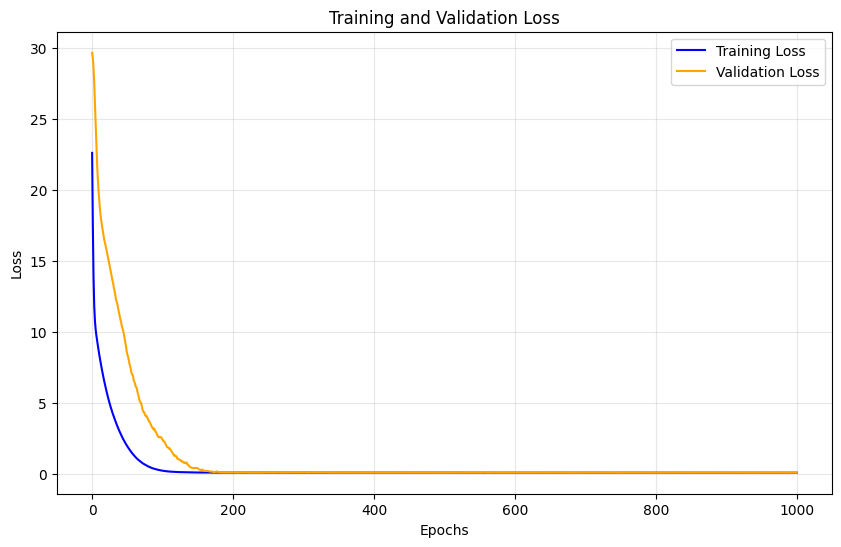

In [4]:
plot_loss(history)

In [12]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

# Prediction & Performance

In [23]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 12ms/step


In [24]:
X_emis_test[18]

array([0.81538172, 1.11554962, 1.09052798, 0.95886025, 0.57191188,
       1.21518621, 1.17809668, 1.19762422, 1.10234056, 1.28606321,
       1.11080942, 1.3128983 , 1.16020392, 1.19391959, 1.0188775 ,
       1.03938011, 1.18747818, 1.04983655, 0.97262597, 0.99741723,
       0.79533562, 0.90015688, 0.82735444, 0.89800689, 1.18278677,
       1.18172214, 1.1902329 , 1.28350387, 0.98254825, 0.96507681,
       0.88991129, 0.90506988, 0.77388705, 1.03215871, 1.30477265,
       1.20661095, 1.16056896, 0.69183552, 1.20525367, 1.12659386,
       0.69273192, 0.97098308, 1.09488342, 0.64935481, 1.22104902,
       1.34472755, 1.13329151, 1.1963949 , 1.25394576, 1.22712673,
       0.91624166, 1.02513585, 1.2369763 , 0.86074779, 1.25937038,
       1.24046512, 0.72014232, 1.42036846, 1.04307555, 1.31060005,
       0.69171331, 0.71990495, 0.91142314, 0.69095794, 1.40073342,
       0.69038503, 0.68636916, 0.64088837, 0.8070049 , 1.49660479,
       1.14956261, 0.85470968, 1.13691181, 1.05873891, 1.03603

In [25]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [72]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=95, axis=1)
    # y_err_std = np.std(y_norm_err, axis=1)  # (48,)
    return y_err_mean, y_err_std

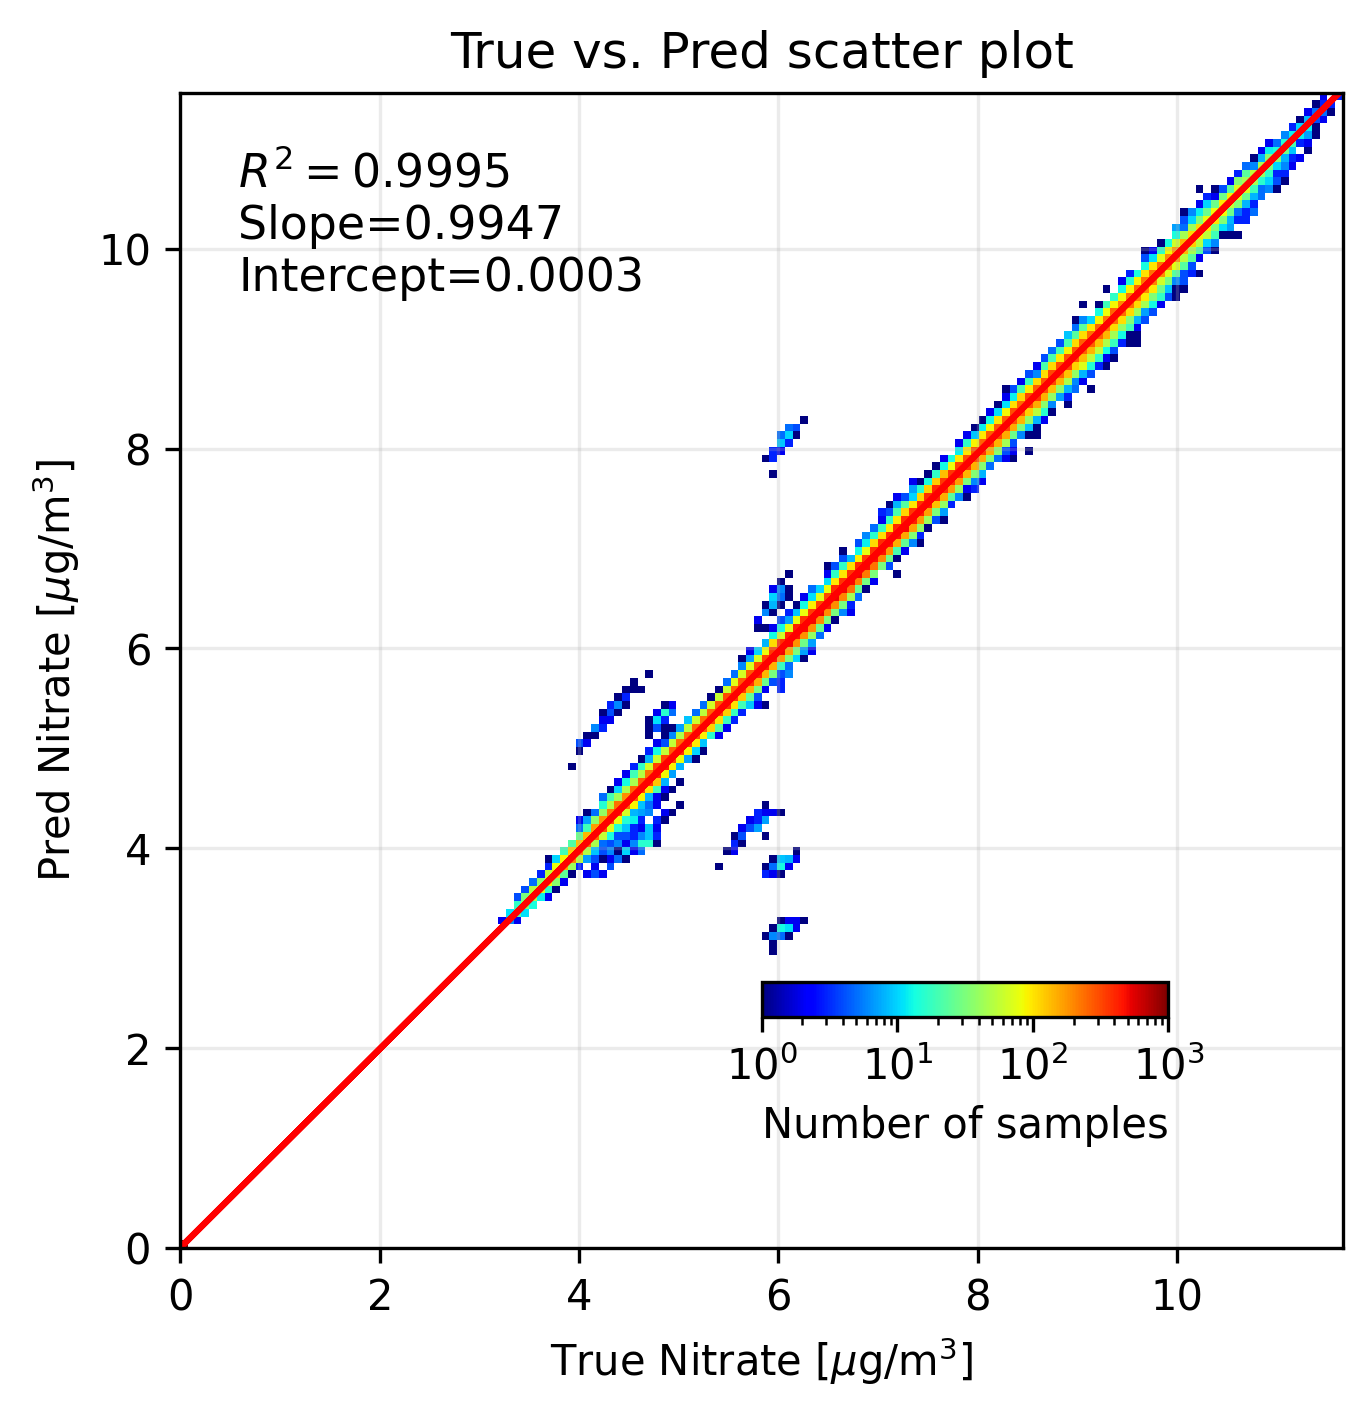

In [30]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

In [70]:
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)

In [71]:
print(score)
print(score_std)

[0.01438665 0.00927017 0.00880075 0.00842701 0.01397307 0.00925551
 0.00995033 0.00899369 0.01181739 0.0094801  0.00918952 0.00955114
 0.01000082 0.00848656 0.00773138 0.00848147 0.00902832 0.00896415
 0.01060338 0.00852818 0.00840772 0.01182685 0.01099382 0.01475473
 0.00971547 0.01093129 0.0090757  0.01016332 0.00910928 0.00844579
 0.00922907 0.0132389  0.01472676 0.00927953 0.00919008 0.00923454
 0.0079257  0.01902637 0.00919144 0.00975668 0.00833097 0.00853152
 0.00894263 0.00853679 0.00811913 0.00736134 0.00817832 0.0098168 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


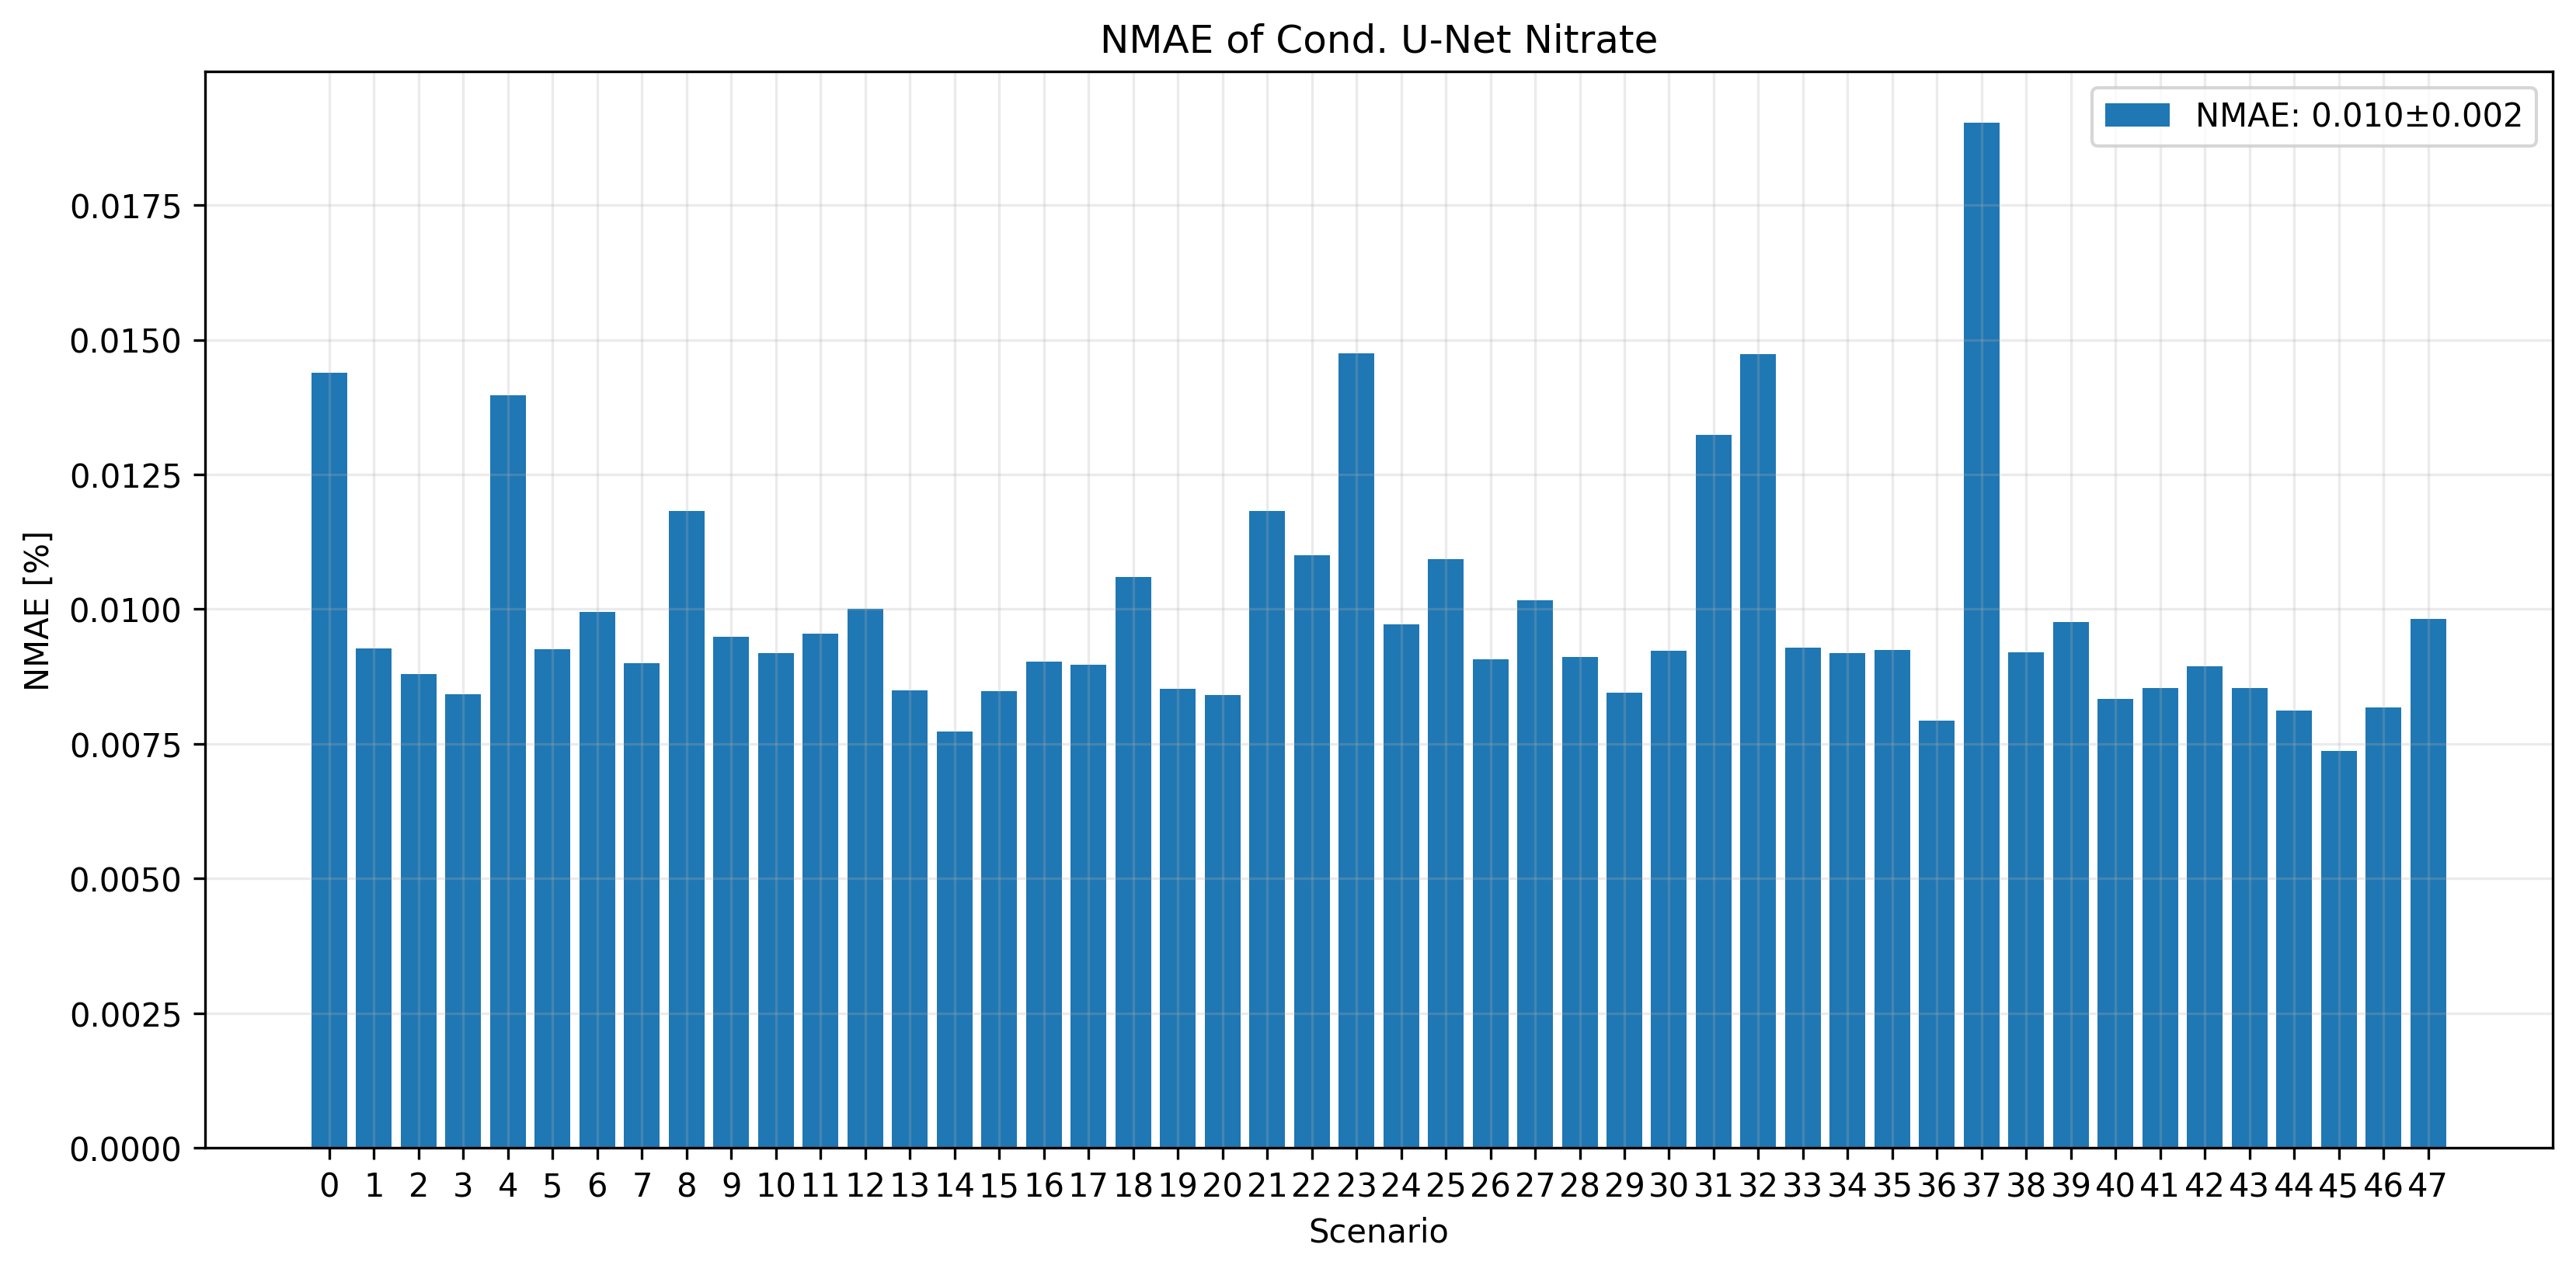

In [73]:
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

[0]


/tmp/ipykernel_1147194/815748241.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1147194/815748241.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1147194/815748241.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1147194/815748241.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1147194/815748241.py:67: UserWarning: set_ticklab

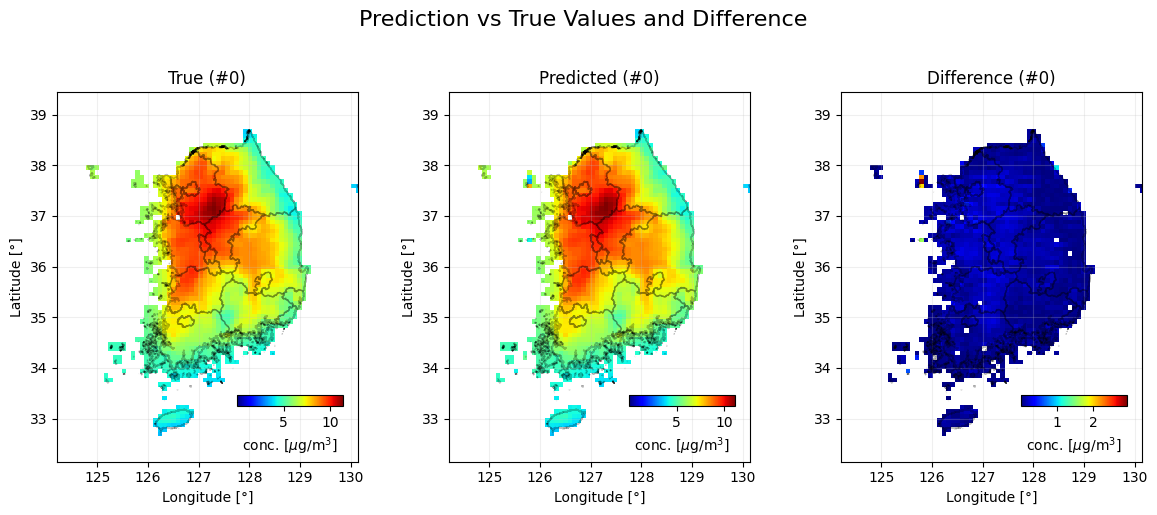

In [32]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=0)